In [1]:
import osmnx as ox
import networkx as nx
import pandas as pd
from skimage.graph import MCP_Geometric
import numpy as np
import networkx as nx
import osmnx as ox
import pickle
import folium
import requests
import json
import matplotlib.pyplot as plt

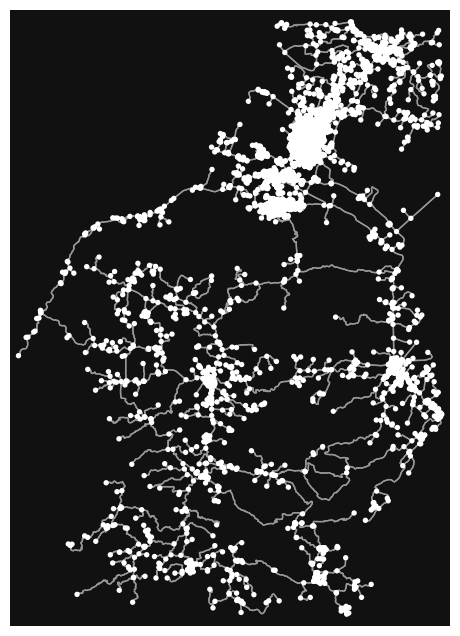

In [2]:

def get_bounding_box(query):
    url = "https://nominatim.openstreetmap.org/search"
    params = {
        "q": query,
        "format": "json",
        "limit": 1,
    }

    response = requests.get(url, params=params)
    result = response.json()
    return [float(coord) for coord in result[0]['boundingbox']]

bbox_norte = get_bounding_box("North Upi, Philippines")
bbox_sur = get_bounding_box("Datu Blah T. Sinsuat, Philippines")
bbox_south_upi = get_bounding_box("South Upi, Philippines")
bbox_datu_odin_sinsuat = get_bounding_box("Datu Odin Sinsuat, Philippines")
bbox_cotabato_city = get_bounding_box("Cotabato City, Philippines")

# Combine the bounding boxes
south = min(bbox_norte[0], bbox_sur[0], bbox_south_upi[0], bbox_datu_odin_sinsuat[0], bbox_cotabato_city[0])
north = max(bbox_norte[1], bbox_sur[1], bbox_south_upi[1], bbox_datu_odin_sinsuat[1], bbox_cotabato_city[1])
west = min(bbox_norte[2], bbox_sur[2], bbox_south_upi[2], bbox_datu_odin_sinsuat[2], bbox_cotabato_city[2])
east = max(bbox_norte[3], bbox_sur[3], bbox_south_upi[3], bbox_datu_odin_sinsuat[3], bbox_cotabato_city[3])

# Retrieve the road network for the combined bounding box
graph_2 = ox.graph_from_bbox(north, south, east, west, network_type='drive')

# Plot the road network
fig, ax = ox.plot_graph(graph_2)


In [3]:
end_point = (7.0198506, 124.1646850)
end_node = ox.distance.nearest_nodes(graph_2, X=[end_point[1]], Y=[end_point[0]])[0]

In [4]:
# Add a travel time attribute to the edges, assuming an average speed of 30 km/h
for u, v, data in graph_2.edges(data=True):
    data['travel_time'] = data['length'] / (30 * 1000 / 3600)  # Convert the average speed to m/s

stats = ox.stats.basic_stats(graph_2, area=None)

# Calculate the total travel time in seconds
total_travel_time = sum(data['travel_time'] for u, v, data in graph_2.edges(data=True))

# Calculate the average speed in km/h
avg_speed = (stats['edge_length_total'] / 1000) / (total_travel_time / 3600)

print(f"Average speed: {avg_speed:.2f} km/h")

# Find the nodes that are within the desired access time
desired_access_time = 60  # minutes
# avg_speed = 30  # km/h
nodes_within_time = {}
for node in graph_2.nodes():
    try:
        path_length = nx.shortest_path_length(graph_2, end_node, node, weight='length')
        travel_time = (path_length / 1000) / avg_speed * 60  # Convert to minutes
        if travel_time <= desired_access_time:
            nodes_within_time[node] = travel_time
    except nx.NetworkXNoPath:
        continue

# # Plot the graph, highlighting the nodes within the desired access time
# nc = ['red' if node in nodes_within_time else 'blue' for node in graph_2.nodes()]
# ox.plot_graph(graph_2, node_color=nc, node_zorder=3)

Average speed: 30.00 km/h


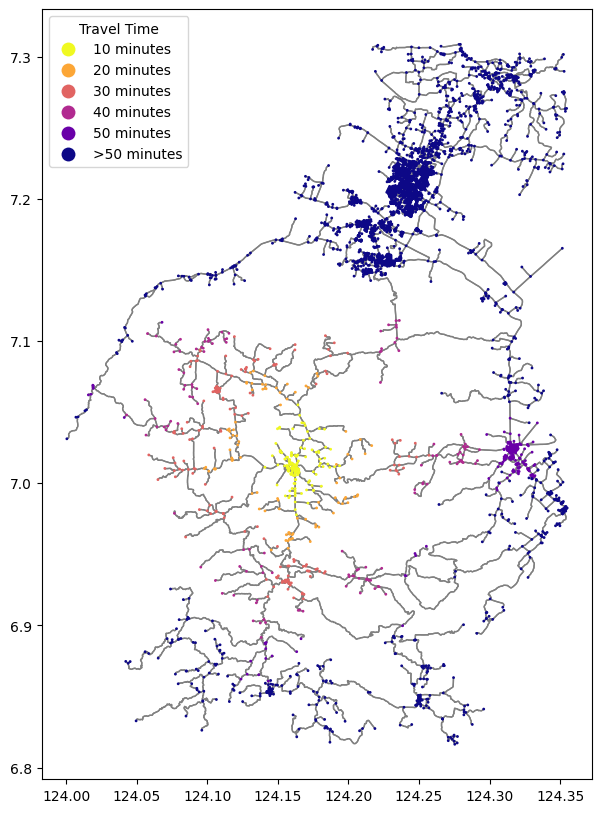

In [5]:
import osmnx as ox
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

# Your previous code for retrieving the road network and adding the 'travel_time' attribute
# ...

# Find the shortest path lengths (in minutes) from the end_node to all other nodes
shortest_paths = nx.shortest_path_length(graph_2, source=end_node, weight='travel_time')
shortest_paths_minutes = {node: length / 60 for node, length in shortest_paths.items()}

# Convert the graph to a GeoDataFrame
nodes, edges = ox.graph_to_gdfs(graph_2)

# Add the travel times to the nodes DataFrame
nodes['travel_time'] = nodes.index.map(shortest_paths_minutes)

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the road network on the bottom layer
edges = gpd.GeoDataFrame(edges)
edges.plot(ax=ax, linewidth=1, color='gray', zorder=1)

# Plot the isochrone points on the top layer
iso_colors = ox.plot.get_colors(n=5, cmap='plasma', start=0, return_hex=True)
isochrone_intervals = [10, 20, 30, 40, 50]  # Define your desired isochrone intervals (in minutes)
nodes.plot(column='travel_time', cmap='plasma_r', scheme='User_Defined', ax=ax,
           classification_kwds={'bins': isochrone_intervals}, legend=True,
           markersize=1, zorder=2)

# Customize the appearance of the legend
legend = ax.get_legend()
for i, label in enumerate(legend.get_texts()[:-1]):
    label.set_text(f"{isochrone_intervals[i]:.0f} minutes")
legend.get_texts()[-1].set_text(f">{isochrone_intervals[-1]:.0f} minutes")
legend.set_title("Travel Time")

plt.show()
